<a href="https://colab.research.google.com/github/salwaa-hub/tubes_machinelearning/blob/main/tubes_machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tugas Besar Machine Learning Semester 4 - Salwa Salsabila Daffa'atulhaq (4.33.23.2.25)**

## **Long Short-Term Memory**

***Eksplorasi Data Awal***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data ---
df = pd.read_csv("weatherHistory.csv")

# --- Info Dataset ---
print("\n=== STRUKTUR DATASET ===")
print(df.info())

# --- Konversi Kolom Waktu ---
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], utc=True)

# --- Urutkan Berdasarkan Waktu ---
df.sort_values("Formatted Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# --- Contoh Record (Baris Data) ---
print("\n=== CONTOH RECORD (5 BARIS PERTAMA) ===")
print(df.head())  # Tampilkan contoh data (baris-baris awal)

# --- Statistik Deskriptif ---
print("\n=== STATISTIK DESKRIPTIF ===")
print(df.describe())

# --- Cek Missing Values ---
print("\n=== JUMLAH MISSING VALUES ===")
print(df.isnull().sum())

# --- Split Data (Contoh Pemisahan Training dan Testing) ---
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

# --- Analisis Dimensi Dataset ---
print("\n=== ANALISIS DIMENSI DATASET ===")
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Total kolom dalam train data: {train_data.shape[1]}")
print(f"Total kolom dalam test data: {test_data.shape[1]}")

# --- Analisis Fitur ---
print("\n=== ANALISIS FITUR ===")
print(f"Total fitur (termasuk target): {len(train_data.columns)}")
print(f"Fitur numerik: {len(train_data.select_dtypes(include=[np.number]).columns)}")
print(f"Fitur kategorikal: {len(train_data.select_dtypes(include=['object']).columns)}")


=== STRUKTUR DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
None

=== CONTOH RECORD (5 BARIS PERTAMA) =

***Praproses Data***

In [ ]:
# Drop kolom non-numerik
df.drop(columns=["Summary", "Precip Type", "Daily Summary"], inplace=True)

# Hapus missing values
df.dropna(inplace=True)

# Normalisasi fitur numerik
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi dan fit scaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=["Formatted Date"]))

# Gabungkan kembali ke DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])
df_scaled["Formatted Date"] = df["Formatted Date"].values
df_scaled = df_scaled[["Formatted Date"] + list(df_scaled.columns[:-1])]

***Heatmap Korelasi dan Feature Selected***

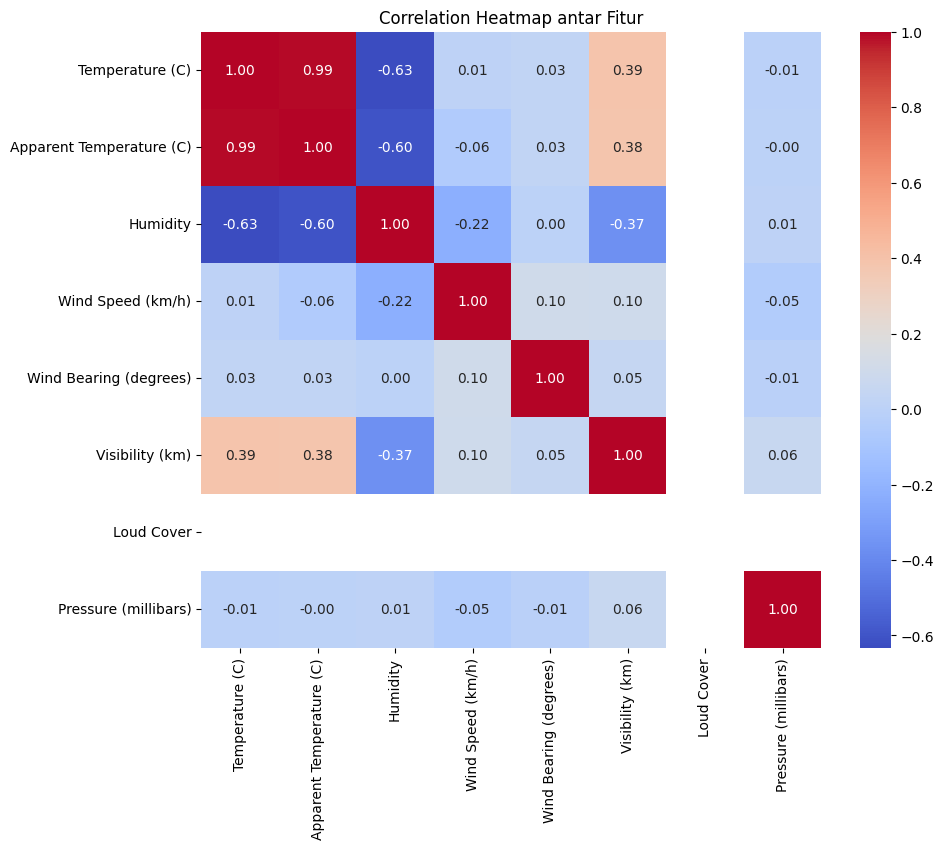


✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2) terhadap 'Temperature (C)':
['Apparent Temperature (C)', 'Humidity', 'Visibility (km)']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya kolom numerik (tanpa "Formatted Date" jika ada)
numeric_df = df.select_dtypes(include=["float64", "int64"])

# ===== 1. Heatmap Korelasi =====
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap antar Fitur")
plt.show()

# ===== 2. Feature Selection berdasarkan korelasi terhadap 'Temperature (C)' =====
correlation_matrix = numeric_df.corr()
target_corr = correlation_matrix["Temperature (C)"].abs().sort_values(ascending=False)

# Threshold korelasi minimum (misal > 0.2)
threshold = 0.2
selected_features = target_corr[target_corr > threshold].index.tolist()

# Buang target dari daftar fitur input
if "Temperature (C)" in selected_features:
    selected_features.remove("Temperature (C)")

print("\n✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2) terhadap 'Temperature (C)':")
print(selected_features)

# (Opsional) Simpan data hasil seleksi fitur untuk tahap berikutnya
df_selected = df[selected_features + ["Temperature (C)", "Formatted Date"]]

***Normalisasi***

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_selected = df[selected_features + ["Temperature (C)", "Formatted Date"]]

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_selected.drop(columns=["Formatted Date"]))

df_scaled = pd.DataFrame(scaled_values, columns=selected_features + ["Temperature (C)"])
df_scaled["Formatted Date"] = df_selected["Formatted Date"].values

***Window Data untuk LSTM***

In [31]:
import numpy as np
import pandas as pd

def create_lstm_dataset(data, look_back=24):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i][0])  # Target: suhu (kolom ke-0, yaitu Temperature (C))
    return np.array(X), np.array(y)

# === Gunakan hanya fitur terpilih ===
features_to_use = selected_features.copy()  # hanya fitur terpilih
features_to_use.insert(0, "Temperature (C)")  # pastikan target ada di kolom pertama

# Ambil data yang sudah dinormalisasi sesuai fitur yang dipilih
df_lstm = df_scaled[["Formatted Date"] + features_to_use]

# Konversi ke array tanpa kolom waktu
data_values = df_lstm.drop(columns=["Formatted Date"]).values
feature_names = df_lstm.columns[1:]  # tanpa "Formatted Date"

# Buat window dataset
look_back = 24
X, y = create_lstm_dataset(data_values, look_back)

# Cek bentuk data
print("Bentuk X:", X.shape)
print("Bentuk y:", y.shape)

# Tampilkan 1 contoh window (X[0]) sebagai DataFrame
df_window = pd.DataFrame(X[0], columns=feature_names)
df_window.index = [f"Jam {i+1}" for i in range(look_back)]

print("\n🪟 Contoh input window pertama (X[0]) sebagai tabel (24 jam × fitur):")
display(df_window)

# Tampilkan target suhu (scaled)
print("\n🎯 Target suhu (scaled) untuk window pertama (y[0]):")
print(y[0])

# Kembalikan ke suhu asli (jika scaler tersedia)
try:
    dummy = np.zeros((1, scaler.n_features_in_))  # Sesuaikan jumlah kolom ke scaler
    dummy[0, 0] = y[0]  # Kolom suhu ada di posisi pertama
    y_inverse = scaler.inverse_transform(dummy)[0][0]
    print("\n🎯 Target suhu asli (dalam °C) untuk y[0]:", y_inverse)
except Exception as e:
    print("\n⚠️ Tidak bisa inverse transform — pastikan scaler sudah didefinisikan sebelumnya.")

Bentuk X: (96429, 24, 4)
Bentuk y: (96429,)

🪟 Contoh input window pertama (X[0]) sebagai tabel (24 jam × fitur):


,Temperature (C),Apparent Temperature (C),Visibility (km),Humidity
Jam 1,0.362884,0.352912,0.620,0.89
Jam 2,0.372334,0.365007,0.615,0.85
Jam 3,0.380524,0.366250,0.615,0.82
Jam 4,0.381244,0.380582,0.615,0.82
Jam 5,0.372694,0.372380,0.615,0.86
Jam 6,0.373054,0.367492,0.620,0.85
Jam 7,0.389524,0.376108,0.624,0.79
Jam 8,0.387094,0.364510,0.623,0.81
Jam 9,0.389164,0.370806,0.696,0.80
Jam 10,0.397804,0.381493,0.620,0.82



🎯 Target suhu (scaled) untuk window pertama (y[0]):
0.4413644136441365

🎯 Target suhu asli (dalam °C) untuk y[0]: 1.8817213172131708


***Split Data Train/Test***

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

***Bangun dan Latih Model LSTM***

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0086 - mae: 0.0504 - val_loss: 6.6103e-04 - val_mae: 0.0200
Epoch 2/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 6.0623e-04 - mae: 0.0187 - val_loss: 4.1397e-04 - val_mae: 0.0156
Epoch 3/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 5.3881e-04 - mae: 0.0172 - val_loss: 3.4743e-04 - val_mae: 0.0140
Epoch 4/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 4.7206e-04 - mae: 0.0159 - val_loss: 3.7663e-04 - val_mae: 0.0146
Epoch 5/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 4.5765e-04 - mae: 0.0157 - val_loss: 3.0914e-04 - val_mae: 0.0131
Epoch 6/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 4.6307e-04 - mae: 0.0157 - val_loss: 3.3250e-04 - val_mae: 0.0135
Epoch 7/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 4.5890e-04 - mae: 0.0157 - val_loss: 3.3168e-04 - val_mae: 0.0137
Epoch 8/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 4.4688e-04 - mae: 0.0154 - val_loss: 3.6995e-0

9. Evaluasi: RMSE & MAE dalam Celcius

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prediksi
y_pred = model.predict(X_test)

# Inverse transform suhu
y_test_celsius = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), len(selected_features))), y_test.reshape(-1, 1)], axis=1)
)[:, -1]

y_pred_celsius = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), len(selected_features))), y_pred], axis=1)
)[:, -1]

mae = mean_absolute_error(y_test_celsius, y_pred_celsius)
rmse = np.sqrt(mean_squared_error(y_test_celsius, y_pred_celsius))

print(f"MAE  (°C) = {mae:.4f}")
print(f"RMSE (°C) = {rmse:.4f}")

603/603 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
MAE  (°C) = 0.7721
RMSE (°C) = 1.0595


***Visualisasi Prediksi vs Aktual***

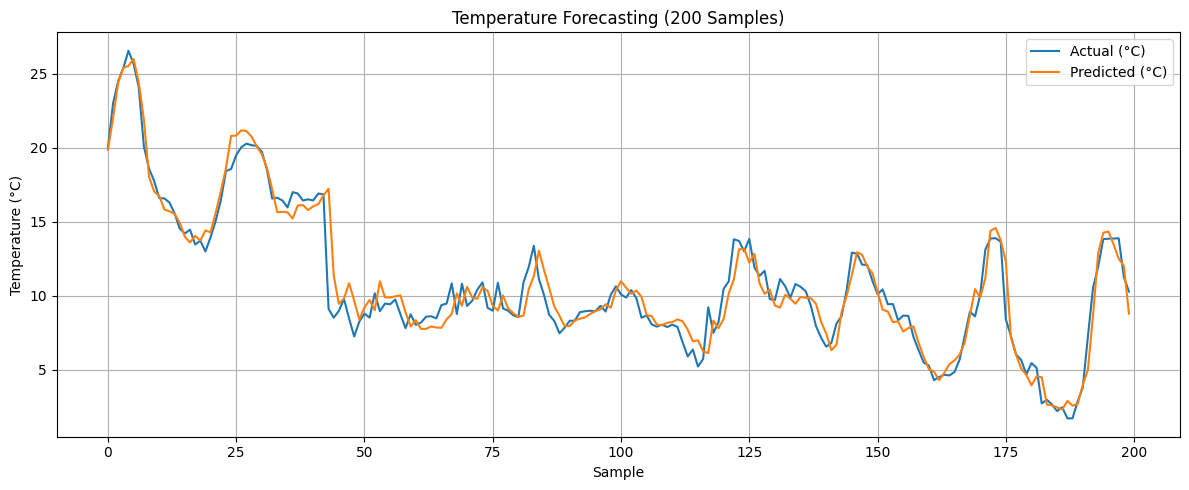

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_celsius[:200], label='Actual (°C)')
plt.plot(y_pred_celsius[:200], label='Predicted (°C)')
plt.title("Temperature Forecasting (200 Samples)")
plt.xlabel("Sample")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

***Visualisasi Training History (Loss & MAE)***

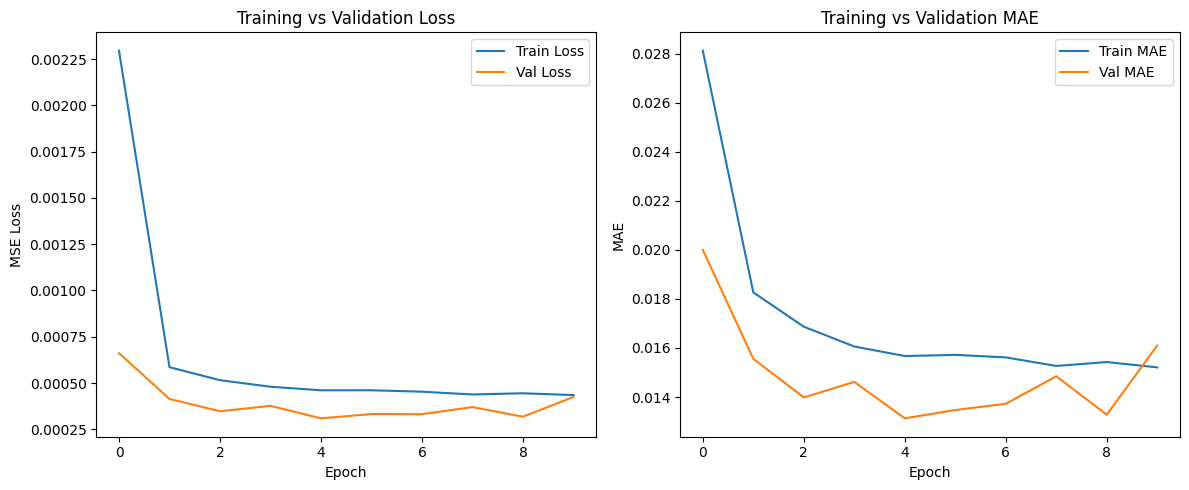

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

##**Recurrent Neural Network**

***Heatmap Korelasi & Feature Selection***

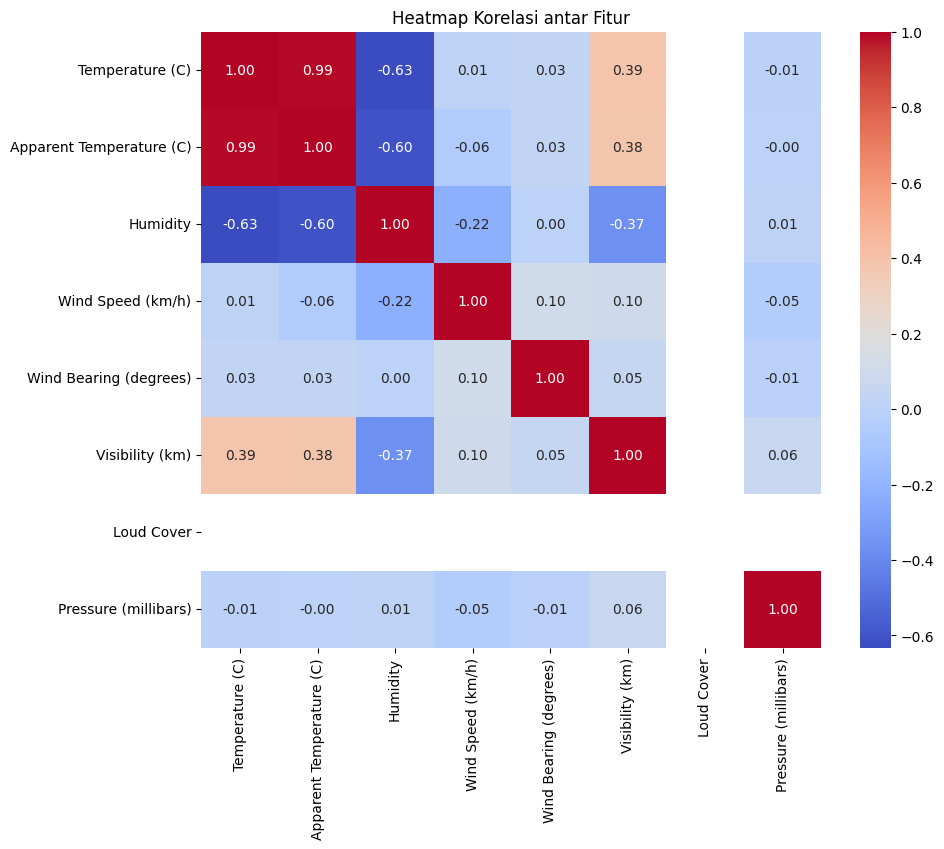


📌 Korelasi terhadap 'Temperature (C)':

Temperature (C)             1.000000
Apparent Temperature (C)    0.992629
Visibility (km)             0.392847
Wind Bearing (degrees)      0.029988
Wind Speed (km/h)           0.008957
Pressure (millibars)       -0.005447
Humidity                   -0.632255
Loud Cover                       NaN
Name: Temperature (C), dtype: float64

✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2):
['Apparent Temperature (C)', 'Visibility (km)', 'Humidity']


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya kolom numerik (tanpa "Formatted Date")
numeric_df = df.select_dtypes(include=["float64", "int64"])

# Hitung korelasi antar fitur
correlation_matrix = numeric_df.corr()

# Tampilkan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi antar Fitur")
plt.show()

# ===== Feature selection berdasarkan korelasi dengan 'Temperature (C)' =====
target_corr = correlation_matrix["Temperature (C)"].sort_values(ascending=False)
print("\n📌 Korelasi terhadap 'Temperature (C)':\n")
print(target_corr)

# Pilih fitur dengan korelasi kuat terhadap Temperature (C)
# Misal threshold korelasi minimal = 0.2
selected_features = target_corr[abs(target_corr) > 0.2].index.tolist()

# Buang 'Temperature (C)' dari daftar fitur input (karena itu target)
selected_features.remove("Temperature (C)")

print("\n✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2):")
print(selected_features)

***Normalisasi***

In [22]:
# --- Ambil hanya fitur terpilih + target + waktu ---
selected_columns = ['Apparent Temperature (C)', 'Humidity', 'Visibility (km)', 'Temperature (C)', 'Formatted Date']
df_rnn = df[selected_columns].copy()

# --- Drop missing values ---
df_rnn.dropna(inplace=True)

# --- Normalisasi fitur numerik ---
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_rnn.drop(columns=["Formatted Date"]))

# Gabungkan lagi ke DataFrame
df_scaled_rnn = pd.DataFrame(scaled_values, columns=df_rnn.columns[:-1])
df_scaled_rnn["Formatted Date"] = df_rnn["Formatted Date"].values

***Windowing Data untuk RNN***

In [23]:
def create_rnn_dataset(data, look_back=24):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i][-1])  # Target: suhu (kolom terakhir)
    return np.array(X), np.array(y)

# Ambil semua data numerik (tanpa tanggal)
data_values = df_scaled_rnn.drop(columns=["Formatted Date"]).values
look_back = 24

# Buat window data
X, y = create_rnn_dataset(data_values, look_back)

# Tampilkan bentuk dataset
print("🔢 X shape:", X.shape)  # (samples, 24, 4)
print("🎯 y shape:", y.shape)

# Cek 1 sample input dan target
pd.DataFrame(X[0], columns=['Apparent Temp', 'Humidity', 'Visibility', 'Temperature'])


🔢 X shape: (96429, 24, 4)
🎯 y shape: (96429,)


,Apparent Temp,Humidity,Visibility,Temperature
0,0.352912,0.89,0.620,0.362884
1,0.365007,0.85,0.615,0.372334
2,0.366250,0.82,0.615,0.380524
3,0.380582,0.82,0.615,0.381244
4,0.372380,0.86,0.615,0.372694
5,0.367492,0.85,0.620,0.373054
6,0.376108,0.79,0.624,0.389524
7,0.364510,0.81,0.623,0.387094
8,0.370806,0.80,0.696,0.389164
9,0.381493,0.82,0.620,0.397804


***Split Train/Val/Test***

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (67500, 24, 4)
Validation: (14464, 24, 4)
Test: (14465, 24, 4)


***Bangun Model RNN***

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(look_back, X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

***Train Model RNN***

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0046 - mae: 0.0372 - val_loss: 5.1226e-04 - val_mae: 0.0178
Epoch 2/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 4.8048e-04 - mae: 0.0164 - val_loss: 5.1671e-04 - val_mae: 0.0185
Epoch 3/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 4.4073e-04 - mae: 0.0155 - val_loss: 2.6066e-04 - val_mae: 0.0121
Epoch 4/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 4.4514e-04 - mae: 0.0155 - val_loss: 3.7545e-04 - val_mae: 0.0151
Epoch 5/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 4.1354e-04 - mae: 0.0149 - val_loss: 3.4825e-04 - val_mae: 0.0148
Epoch 6/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 4.0699e-04 - mae: 0.0147 - val_loss: 2.6746e-04 - val_mae: 0.0123
Epoch 7/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 3.9094e-04 - mae: 0.0143 - val_loss: 2.7619e-04 - val_mae: 0.0127
Epoch 8/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 3.7878e-04 - mae: 0.0140 - val_loss: 3

***Evaluasi Model (RMSE & MAE)***

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred = model.predict(X_test)

# Dummy array untuk inverse_transform
dummy_pred = np.zeros((len(y_pred), 4))
dummy_test = np.zeros((len(y_test), 4))
dummy_pred[:, -1] = y_pred.flatten()
dummy_test[:, -1] = y_test.flatten()

# Inverse transform hanya kolom target (Temperature)
y_pred_inv = scaler.inverse_transform(dummy_pred)[:, -1]
y_test_inv = scaler.inverse_transform(dummy_test)[:, -1]

# Error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"📉 RMSE: {rmse:.4f} °C")
print(f"📉 MAE: {mae:.4f} °C")

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
📉 RMSE: 1.0227 °C
📉 MAE: 0.7515 °C


***Visualisasi Loss dan MAE***

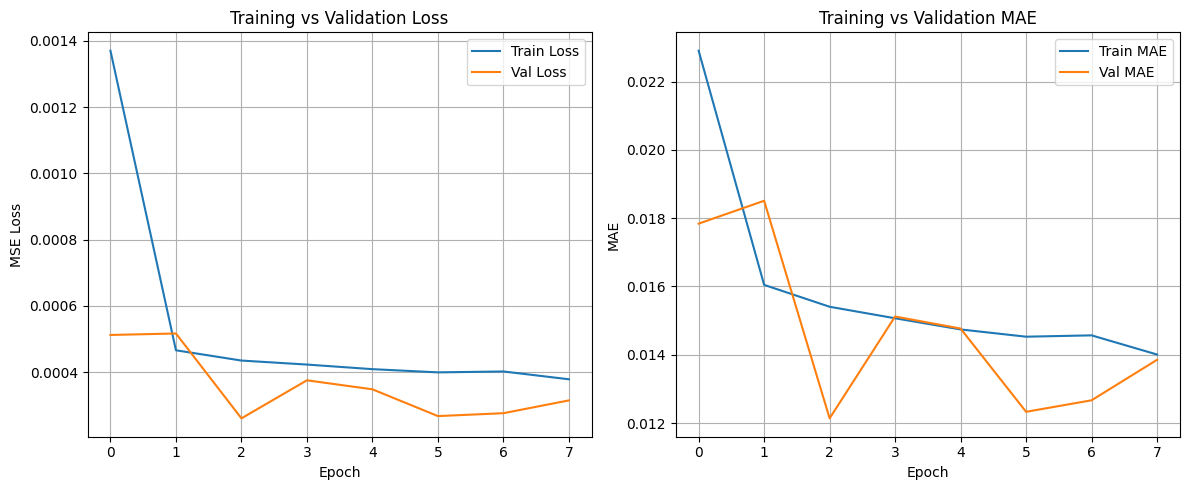

In [28]:
plt.figure(figsize=(12, 5))

# Plot MSE Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

***Visualisasi Prediksi vs Aktual***

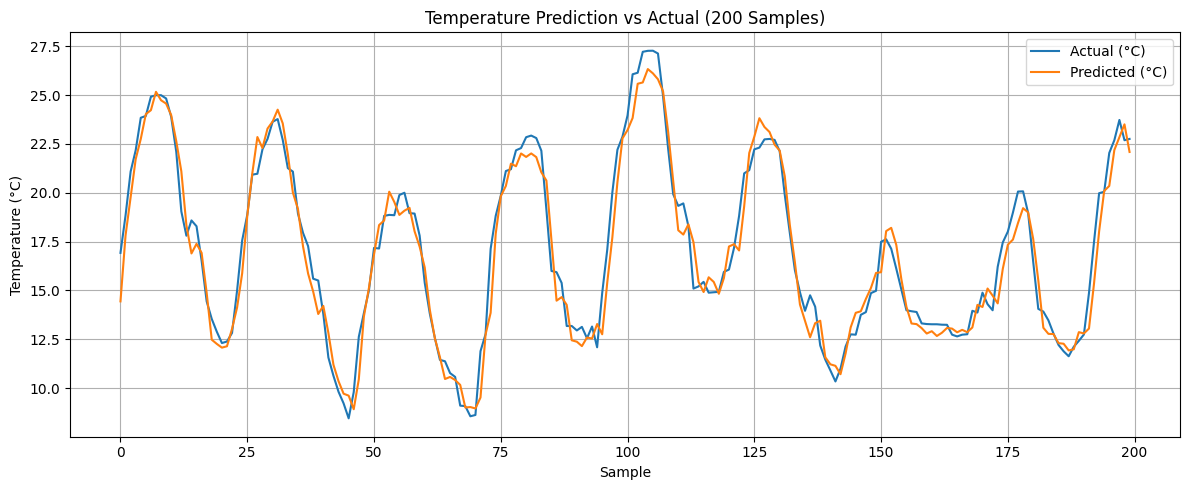

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Actual (°C)')
plt.plot(y_pred_inv[:200], label='Predicted (°C)')
plt.title("Temperature Prediction vs Actual (200 Samples)")
plt.xlabel("Sample")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()